In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns

In [14]:
def FH_N_MMO(t, y, a=5, tau_n=60, I=-4.2, Tau_adapt=150, delta=0.2):
    v, n, I_adapt = y
    dvdt = v - (v**3) / 3 - n + I - I_adapt
    dndt = (a * v - n) / tau_n
    dIdt = -I_adapt/Tau_adapt

    if dvdt <= 0 and v == 0:
        dIdt = 0

    return np.array([dvdt, dndt, dIdt])

In [15]:
y0 = [-0.5, -3.0, -4.2]
t_span = [0,200]

soln = solve_ivp(FH_N_MMO, t_span, y0, rtol=1e-8, atol=1e-6)

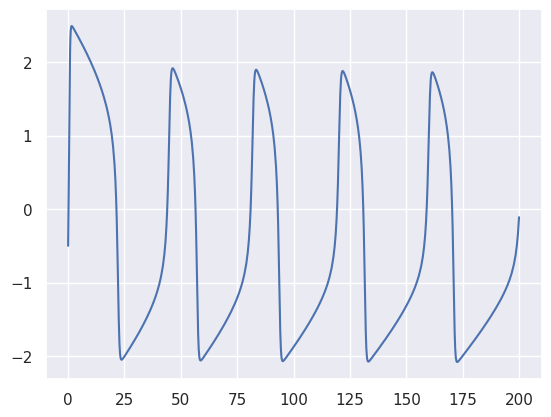

In [16]:
sns.set_theme(style="darkgrid")
plt.plot(soln.t, soln.y[0])
plt.show()

In [17]:
def FH_N_MMO(t, u0, t_span:list, m_steps:int, a=5, tau_n=60, I_ext=-4.2, tau_adapt=150,delta=0.2):
    t = np.linspace(t_span[0], t_span[1], m_steps+1)
    dt = (t_span[1] - t_span[0]) / m_steps
    dt05 = dt/2

    v = np.zeros(m_steps + 1)
    n = np.zeros(m_steps + 1)
    I_adapt = -delta

    v[0] = u0[0]
    n[0] = u0[1]

    I_adapt_list = []

    for k in range(m_steps):
        # First half-step
        v_inc = v[k] - v[k]**3 / 3 - n[k] + I_ext + I_adapt
        n_inc = (a * v[k] - n[k]) / tau_n
        v_tmp = v[k] + dt05 * v_inc
        n_tmp = n[k] + dt05 * n_inc

        # Second half-step
        I_adapt_half = I_adapt * np.exp(-dt05 / tau_adapt)
        v_inc = v_tmp - v_tmp**3 / 3 - n_tmp + I_ext + I_adapt_half
        n_inc = (a * v_tmp - n_tmp) / tau_n

        # Full update
        v[k + 1] = v[k] + dt * v_inc
        n[k + 1] = n[k] + dt * n_inc
        I_adapt = I_adapt * np.exp(-dt / tau_adapt)

        # Spike detection and adaptation jump
        if v[k + 1] < 0 and v[k] >= 0:
            I_adapt -= delta
        
        I_adapt_list.append(I_adapt)

    I_adapt_list = np.array(I_adapt_list)

    return t,v,I_adapt_list
    

In [18]:
# Parameters
a = 5
tau_n = 60
I_ext = -4.2
tau_adapt = 150
delta = 0.2

# Time setup
t_final = 1000
dt = 0.01
dt05 = dt / 2
m_steps = round(t_final / dt)
t = np.linspace(0, t_final, m_steps + 1)

## Control Plot with Constant Applied Current

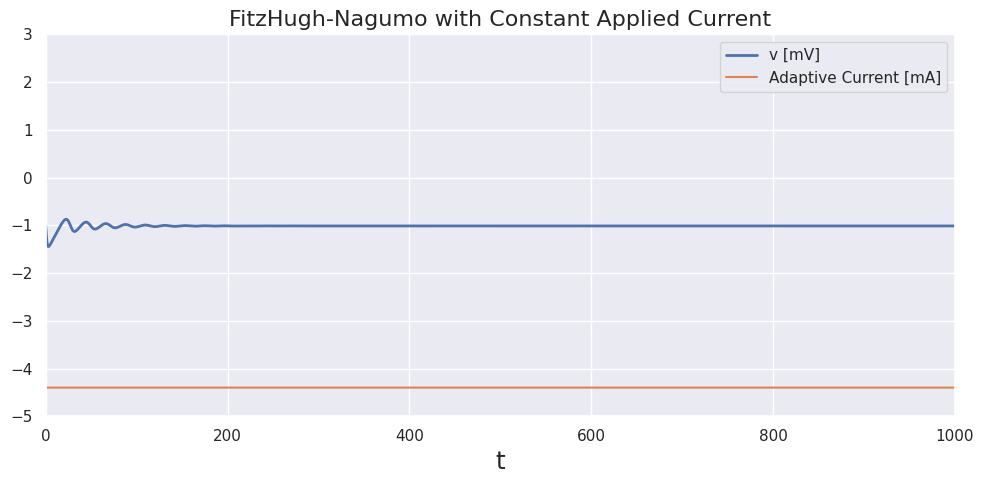

In [25]:
# Initialize variables
v = np.zeros(m_steps + 1)
n = np.zeros(m_steps + 1)
I_adapt_list = []
I_adapt = -delta

# Initial conditions
v[0] = -1
n[0] = -4.75

# Integration loop
for k in range(m_steps):
    # First half-step
    v_inc = v[k] - v[k]**3 / 3 - n[k] + I_ext + I_adapt
    n_inc = (a * v[k] - n[k]) / tau_n
    v_tmp = v[k] + dt05 * v_inc
    n_tmp = n[k] + dt05 * n_inc

    # Second half-step
    I_adapt_half = I_adapt * np.exp(-dt05 / tau_adapt)
    v_inc = v_tmp - v_tmp**3 / 3 - n_tmp + I_ext + I_adapt_half
    n_inc = (a * v_tmp - n_tmp) / tau_n

    # Full update
    v[k + 1] = v[k] + dt * v_inc
    n[k + 1] = n[k] + dt * n_inc
    # I_adapt = I_adapt * np.exp(-dt / tau_adapt)

    # # Spike detection and adaptation jump
    # if v[k + 1] < 0 and v[k] >= 0:
    #     I_adapt -= delta
    
    I_adapt_list.append(I_adapt)

I_adapt_list = np.array(I_adapt_list)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, v, linewidth=2)
plt.plot(t[1:],I_adapt_list - 4.2)
plt.xlabel('t', fontsize=18)
plt.legend(["v [mV]","Adaptive Current [mA]"])
plt.title('FitzHugh-Nagumo with Constant Applied Current', fontsize=16)
plt.grid(True)
plt.ylim([-5, 3])
plt.xlim([0, t_final])
plt.tight_layout()
# plt.show()
plt.savefig("../assets/FHN_ConstantCurrent.png", dpi=300)

## Control Plot with Exponential Applied Current

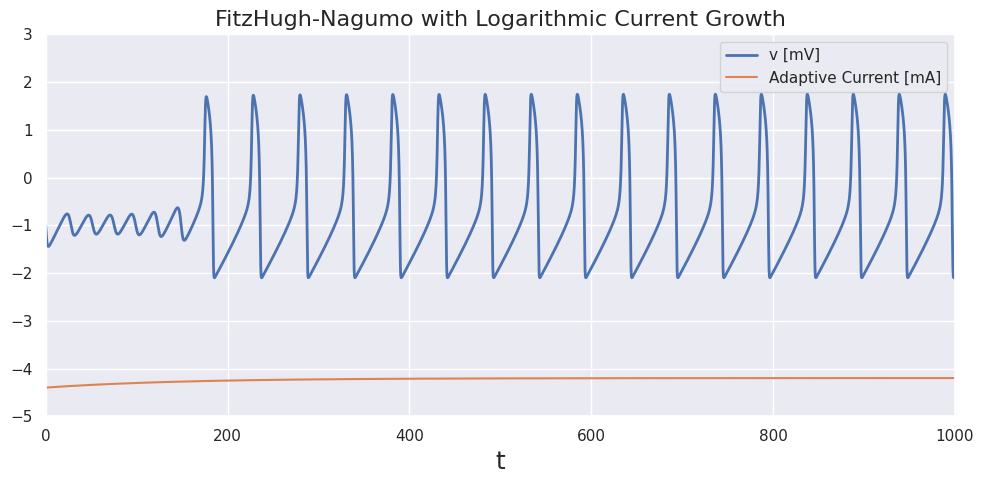

In [ ]:
# Initialize variables
v = np.zeros(m_steps + 1)
n = np.zeros(m_steps + 1)
I_adapt_list = []
I_adapt = -delta

# Initial conditions
v[0] = -1
n[0] = -4.75

# Integration loop
for k in range(m_steps):
    # First half-step
    v_inc = v[k] - v[k]**3 / 3 - n[k] + I_ext + I_adapt
    n_inc = (a * v[k] - n[k]) / tau_n
    v_tmp = v[k] + dt05 * v_inc
    n_tmp = n[k] + dt05 * n_inc

    # Second half-step
    I_adapt_half = I_adapt * np.exp(-dt05 / tau_adapt)
    v_inc = v_tmp - v_tmp**3 / 3 - n_tmp + I_ext + I_adapt_half
    n_inc = (a * v_tmp - n_tmp) / tau_n

    # Full update
    v[k + 1] = v[k] + dt * v_inc
    n[k + 1] = n[k] + dt * n_inc
    I_adapt = I_adapt * np.exp(-dt / tau_adapt)

    # # Spike detection and adaptation jump
    # if v[k + 1] < 0 and v[k] >= 0:
    #     I_adapt -= delta
    
    I_adapt_list.append(I_adapt)

I_adapt_list = np.array(I_adapt_list)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, v, linewidth=2)
plt.plot(t[1:],I_adapt_list - 4.2)
plt.xlabel('t', fontsize=18)
plt.legend(["v [mV]","Adaptive Current [mA]"])
plt.title('FitzHugh-Nagumo with Logarithmic Current Growth', fontsize=16)
plt.grid(True)
plt.ylim([-5, 3])
plt.xlim([0, t_final])
plt.tight_layout()
plt.show()
# plt.savefig("../assets/FHN_GrowingCurrent.png", dpi=300)

## Control Plot with Linear Adaptive (Resets at Canard Explosion) Current

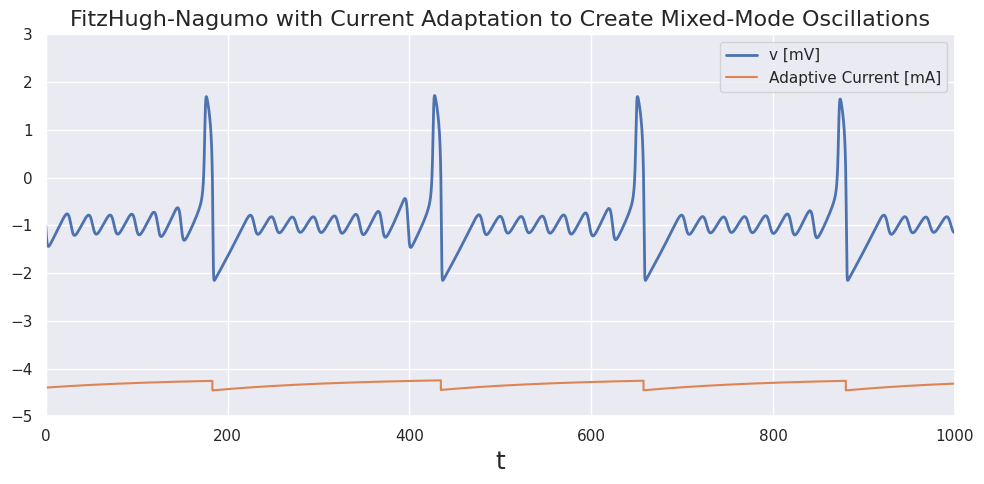

In [23]:
# Initialize variables
v = np.zeros(m_steps + 1)
n = np.zeros(m_steps + 1)
I_adapt_list = []
I_adapt = -delta

# Initial conditions
v[0] = -1
n[0] = -4.75

# Integration loop
for k in range(m_steps):
    # First half-step
    v_inc = v[k] - v[k]**3 / 3 - n[k] + I_ext + I_adapt
    n_inc = (a * v[k] - n[k]) / tau_n
    v_tmp = v[k] + dt05 * v_inc
    n_tmp = n[k] + dt05 * n_inc

    # Second half-step
    I_adapt_half = I_adapt * np.exp(-dt05 / tau_adapt)
    v_inc = v_tmp - v_tmp**3 / 3 - n_tmp + I_ext + I_adapt_half
    n_inc = (a * v_tmp - n_tmp) / tau_n

    # Full update
    v[k + 1] = v[k] + dt * v_inc
    n[k + 1] = n[k] + dt * n_inc
    I_adapt = I_adapt * np.exp(-dt / tau_adapt)

    # Spike detection and adaptation jump
    if v[k + 1] < 0 and v[k] >= 0:
        I_adapt -= delta
    
    I_adapt_list.append(I_adapt)

I_adapt_list = np.array(I_adapt_list)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, v, linewidth=2)
plt.plot(t[1:],I_adapt_list - 4.2)
plt.xlabel('t', fontsize=18)
plt.legend(["v [mV]","Adaptive Current [mA]"])
plt.title('FitzHugh-Nagumo with Current Adaptation to Create Mixed-Mode Oscillations', fontsize=16)
plt.grid(True)
plt.ylim([-5, 3])
plt.xlim([0, t_final])
plt.tight_layout()
plt.show()
# plt.savefig("../assets/MMO_Canard.png", dpi=300)